# Studying Ablations of the Nonparametric Analysis
---
*Ablation studies validating the design of the nonparametric analysis*

For more background, see the notebook [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb) or our paper: [**Show Your Work with Confidence: Confidence Bands for Tuning Curves**](https://arxiv.org/abs/2311.09480).

In [1]:
# imports

import json
import warnings

from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

from experiments import visualization
from opda import nonparametric
import opda.random

# constants

evaluations = {
    "matched": {
        "name": "MultiNLI-m",
    },
    "mismatched": {
        "name": "MultiNLI-mm",
    },
}

models = {
    "deberta-base": {
        "name": "DeBERTa",
        "style": {"linestyle": "-", "color": "#FFB000"},
    },
    "deberta-v3-base": {
        "name": "DeBERTaV3",
        "style": {"linestyle": "--", "color": "#648FFF"},
    },
}

bands = {
    "dkw": {
        "name": "DKW",
        "method": "dkw",
        "style": {"linestyle": "-.", "color": "#FE6100"},
    },
    "ks": {
        "name": "KS",
        "method": "ks",
        "style": {"linestyle": "-", "color": "#FFB000"},
    },
    "ld_equal_tailed": {
        "name": "LD (equal-tailed)",
        "method": "ld_equal_tailed",
        "style": {"linestyle": ":", "color": "#785EF0"},
    },
    "ld_highest_density": {
        "name": "LD (highest density)",
        "method": "ld_highest_density",
        "style": {"linestyle": "--", "color": "#648FFF"},
    },
}


# experimental settings

evaluation = "matched"
model = "deberta-v3-base"
band = "ld_highest_density"

sample_sizes = [6, 20, 34, 48]
n = sample_sizes[-1]  # Later analyses assume n == sample_sizes[-1]
ns_grid = np.linspace(1, n, num=10_000)

y_min = 0.
y_max = 1.
grid = np.linspace(y_min, y_max, num=100)

confidence = 0.80


# Configure environment.

generator = np.random.RandomState(0)
opda.random.set_seed(generator)

warnings.filterwarnings("ignore")


# Configure Matplotlib.

plt.style.use("experiments.default")

## Validating Design Decisions of the Nonparametric Analysis

A natural question to ask is which aspects of the confidence bands' design are important or necessary. To explore this question, we'll run ablation studies to show what happens if we change different parts of the formula.

For these ablations, we use data from fine-tuning DeBERTa and DeBERTaV3 on MultiNLI. For details on the models, dataset, or hyperparameter search space, see the notebook: [Evaluating DeBERTaV3 with the Nonparametric Analysis](./evaluating-debertav3-with-the-nonparametric-analysis.ipynb).

In [2]:
# load the data
model_to_evaluation_to_ys = {}
for model_ in models:
    for evaluation_ in evaluations:
        ys = []
        with open(f"../../data/deberta/{model_}.results.jsonl") as f_in:
            for ln in f_in:
                ex = json.loads(ln)
                ys.append(max(
                    score
                    for _, score in ex["learning_curves"][evaluation_]
                ))
        if model_ not in model_to_evaluation_to_ys:
            model_to_evaluation_to_ys[model_] = {}
        model_to_evaluation_to_ys[model_][evaluation_] = np.array(ys)

total_samples = 1_024
for model_ in models:
    for evaluation_ in evaluations:
        if len(model_to_evaluation_to_ys[model_][evaluation_]) != total_samples:
            raise RuntimeError(
                "The experiment data does not contain the correct"
                " number of examples.",
            )

## DKW vs. KS vs. LD CDF Bands

Our general technique is to translate simultaneous confidence bands for the CDF into simultaneous confidence bands for the tuning curve. Hypothetically, we could start from any simultaneous confidence bands for the CDF. Other bands are easier to compute than the Learned-Miller DeStefano (LD) bands, and perhaps they'd lead to tighter confidence limits on the tuning curve.

As described in [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb#Bounding-the-CDF), the main alternative CDF bands are the Dvoretzky-Kiefer-Wolfowitz and the Kolmogorov-Smirnov bands. Let's compare the three for bounding the CDF:

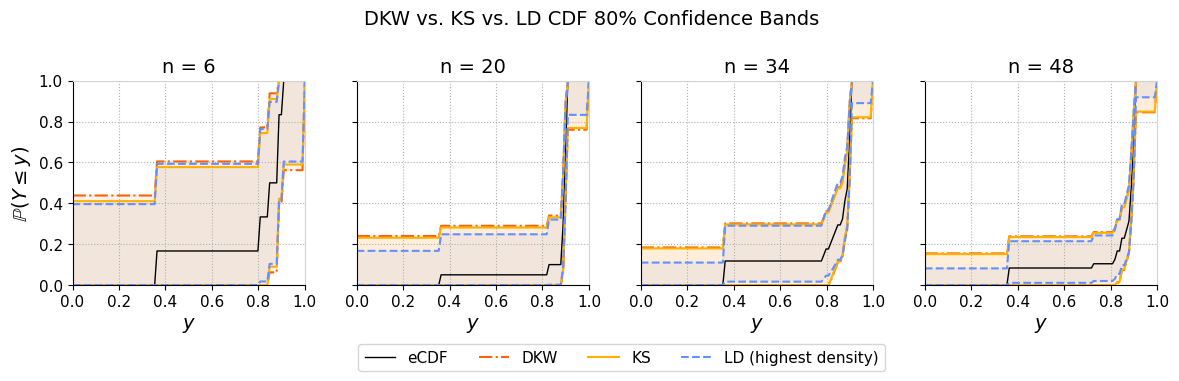

In [3]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    axes[i].plot(
        grid,
        nonparametric.EmpiricalDistribution(ys).cdf(grid),
        linewidth=1,
        linestyle="-",
        color="k",
        label="eCDF",
    )

    for band_ in ["dkw", "ks", "ld_highest_density"]:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        axes[i].plot(
            grid,
            lower_cdf.cdf(grid),
            label=bands[band_]["name"],
            **bands[band_]["style"],
        )
        axes[i].plot(
            grid,
            upper_cdf.cdf(grid),
            **bands[band_]["style"],
        )
        axes[i].fill_between(
            grid,
            lower_cdf.cdf(grid),
            upper_cdf.cdf(grid),
            alpha=0.075,
            **bands[band_]["style"],
        )

# Format the plot.
axes[0].set_ylabel(r"$\mathbb{{P}}(Y \leq y)$")

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(0., 1.)
    axes[i].set_ylim(0., 1.)
    axes[i].set_xlabel("$y$")
    axes[i].set_title(f"n = {sample_size_}")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"DKW vs. KS vs. LD CDF {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1].legend(
    loc="upper left",
    bbox_to_anchor=(-0.025, -0.25),
    ncol=4,
)

plt.show()

We see that for all except the smallest sample sizes, the LD bands are much tighter at the CDF's extremes and almost as tight as the others everywhere else.

This trend holds for both DeBERTa and DeBERTaV3's score distributions:

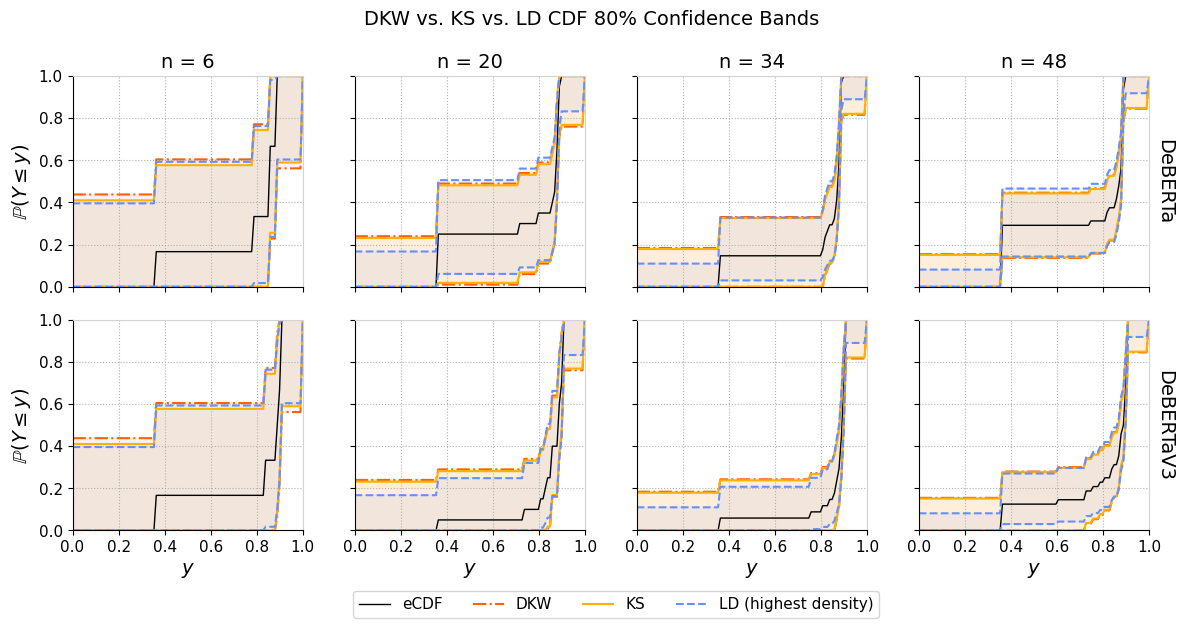

In [4]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = generator.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            grid,
            nonparametric.EmpiricalDistribution(ys).cdf(grid),
            linewidth=1,
            linestyle="-",
            color="k",
            label="eCDF",
        )

        for band_ in ["dkw", "ks", "ld_highest_density"]:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                grid,
                lower_cdf.cdf(grid),
                label=bands[band_]["name"],
                **bands[band_]["style"],
            )
            axes[i, j].plot(
                grid,
                upper_cdf.cdf(grid),
                **bands[band_]["style"],
            )
            axes[i, j].fill_between(
                grid,
                lower_cdf.cdf(grid),
                upper_cdf.cdf(grid),
                alpha=0.075,
                **bands[band_]["style"],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel("$y$")
    axes[0, j].set_title(f"n = {sample_size_}")

for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel(r"$\mathbb{{P}}(Y \leq y)$")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(models[model_]["name"], labelpad=18, rotation=270)

for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(0., 1.)
        axes[i, j].set_ylim(0., 1.)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"DKW vs. KS vs. LD CDF {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1, 1].legend(
    loc="upper left",
    bbox_to_anchor=(-0.04, -0.25),
    ncol=4,
)

plt.show()

So, how do these results for the CDF bands translate to the tuning curve bands?

First, let's compare the tuning curve confidence bands for the smallest and largest sample sizes:

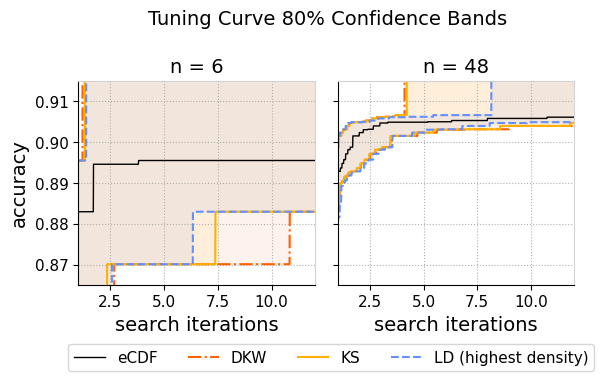

In [5]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle="-",
        color="k",
        label="eCDF",
    )

    for band_ in ["dkw", "ks", "ld_highest_density"]:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]["name"],
            **bands[band_]["style"],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]["style"],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]["style"],
        )

# Format the plot.
axes[0].set_ylabel("accuracy")

for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel("search iterations")
    axes[i].set_title(f"n = {sample_size_}")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"Tuning Curve {100 * confidence:.0f}% Confidence Bands",
    x=0.56,
)

fig.tight_layout()

axes[0].legend(
    loc="upper left",
    bbox_to_anchor=(-0.075, -0.25),
    ncol=4,
)

plt.show()

Because the LD (highest density) CDF confidence bands are much tighter at the upper extreme, the tuning curve bands extend much farther to the right before becoming trivial (jumping to the upper bound on $Y$'s support).

This finding holds across sample sizes:

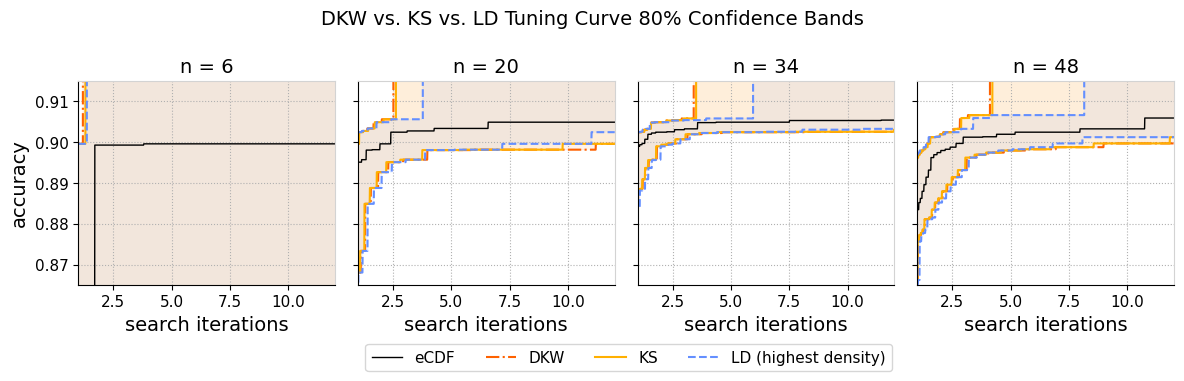

In [6]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle="-",
        color="k",
        label="eCDF",
    )

    for band_ in ["dkw", "ks", "ld_highest_density"]:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]["name"],
            **bands[band_]["style"],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]["style"],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]["style"],
        )

# Format the plot.
axes[0].set_ylabel("accuracy")

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel("search iterations")
    axes[i].set_title(f"n = {sample_size_}")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"DKW vs. KS vs. LD Tuning Curve {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1].legend(
    loc="upper left",
    bbox_to_anchor=(0., -0.25),
    ncol=4,
)

plt.show()

as well as for both DeBERTa and DeBERTaV3:

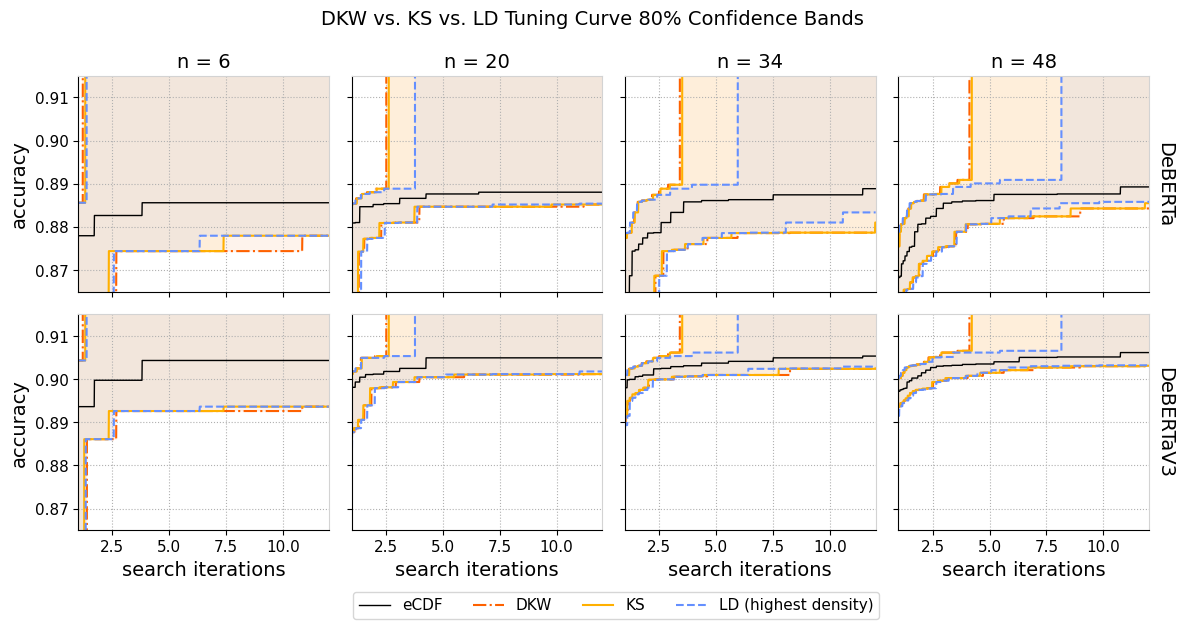

In [7]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = generator.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            ns_grid,
            nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
            linewidth=1,
            linestyle="-",
            color="k",
            label="eCDF",
        )

        for band_ in ["dkw", "ks", "ld_highest_density"]:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                label=bands[band_]["name"],
                **bands[band_]["style"],
            )
            axes[i, j].plot(
                ns_grid,
                lower_cdf.quantile_tuning_curve(ns_grid),
                **bands[band_]["style"],
            )
            axes[i, j].fill_between(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                lower_cdf.quantile_tuning_curve(ns_grid),
                alpha=0.075,
                **bands[band_]["style"],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel("search iterations")
    axes[0, j].set_title(f"n = {sample_size_}")

for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel("accuracy")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(models[model_]["name"], labelpad=18, rotation=270)

for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"DKW vs. KS vs. LD Tuning Curve {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1, 1].legend(
    loc="upper left",
    bbox_to_anchor=(-0.025, -0.25),
    ncol=4,
)

plt.show()

## Equal-tailed vs. Highest Density

The second innovation we recommend in the [**Nonparametric Analysis**](../theory/nonparametric-analysis.ipynb#Bounding-the-CDF) is to use the *highest probability density* intervals when constructing the LD bands, rather than the *equal-tailed* intervals originally used by [Learned-Miller and DeStefano (2005)](http://vis-www.cs.umass.edu/papers/IT_ent_bound.pdf).

Highest probability density intervals are more expensive to compute than equal-tailed intervals; however, they produce tighter confidence bands, since the highest density interval is also the shortest interval with a given coverage. We can see this effect in the following plot:

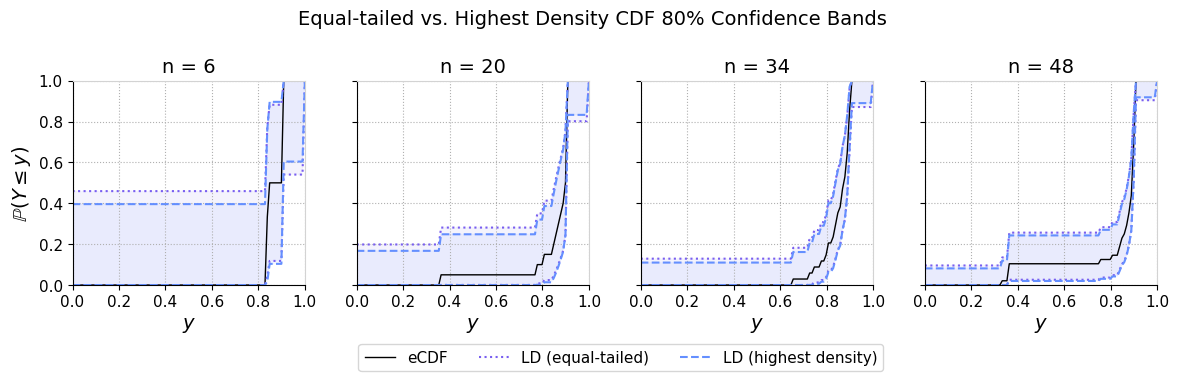

In [8]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    axes[i].plot(
        grid,
        nonparametric.EmpiricalDistribution(ys).cdf(grid),
        linewidth=1,
        linestyle="-",
        color="k",
        label="eCDF",
    )

    for band_ in ["ld_equal_tailed", "ld_highest_density"]:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        axes[i].plot(
            grid,
            lower_cdf.cdf(grid),
            label=bands[band_]["name"],
            **bands[band_]["style"],
        )
        axes[i].plot(
            grid,
            upper_cdf.cdf(grid),
            **bands[band_]["style"],
        )
        axes[i].fill_between(
            grid,
            lower_cdf.cdf(grid),
            upper_cdf.cdf(grid),
            alpha=0.075,
            **bands[band_]["style"],
        )

# Format the plot.
axes[0].set_ylabel(r"$\mathbb{{P}}(Y \leq y)$")

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(0., 1.)
    axes[i].set_ylim(0., 1.)
    axes[i].set_xlabel("$y$")
    axes[i].set_title(f"n = {sample_size_}")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"Equal-tailed vs. Highest Density CDF {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1].legend(
    loc="upper left",
    bbox_to_anchor=(-0.025, -0.25),
    ncol=3,
)

plt.show()

Again, the result is the same for both DeBERTa and DeBERTaV3:

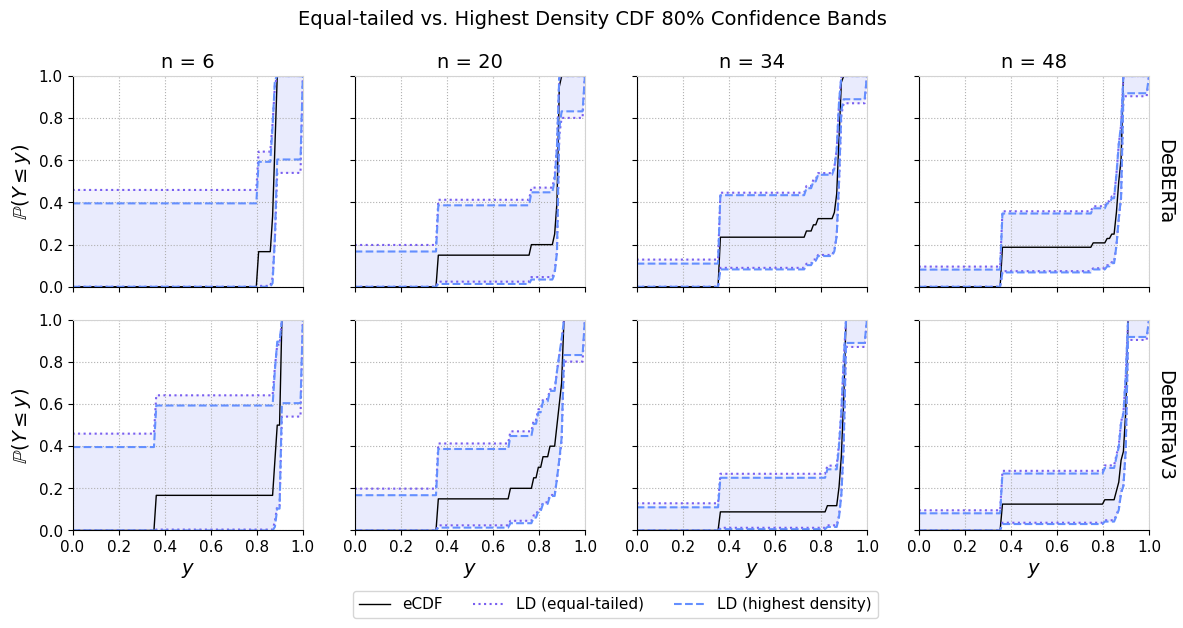

In [9]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = generator.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            grid,
            nonparametric.EmpiricalDistribution(ys).cdf(grid),
            linewidth=1,
            linestyle="-",
            color="k",
            label="eCDF",
        )

        for band_ in ["ld_equal_tailed", "ld_highest_density"]:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                grid,
                lower_cdf.cdf(grid),
                label=bands[band_]["name"],
                **bands[band_]["style"],
            )
            axes[i, j].plot(
                grid,
                upper_cdf.cdf(grid),
                **bands[band_]["style"],
            )
            axes[i, j].fill_between(
                grid,
                lower_cdf.cdf(grid),
                upper_cdf.cdf(grid),
                alpha=0.075,
                **bands[band_]["style"],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel("$y$")
    axes[0, j].set_title(f"n = {sample_size_}")

for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel(r"$\mathbb{{P}}(Y \leq y)$")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(models[model_]["name"], labelpad=18, rotation=270)

for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(0., 1.)
        axes[i, j].set_ylim(0., 1.)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"Equal-tailed vs. Highest Density CDF {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1, 1].legend(
    loc="upper left",
    bbox_to_anchor=(-0.04, -0.25),
    ncol=3,
)

plt.show()

Let's see how these results translate to tuning curves. Starting with the smallest and largest sample size:

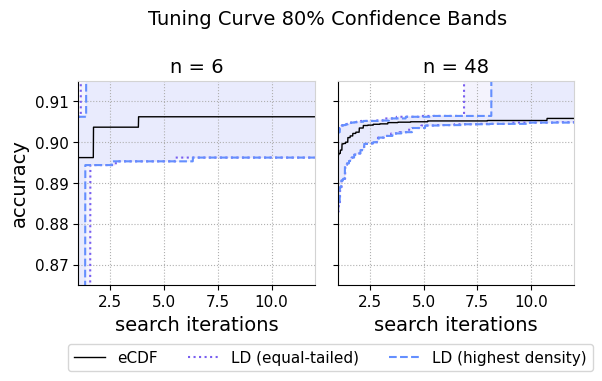

In [10]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)
for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle="-",
        color="k",
        label="eCDF",
    )

    for band_ in ["ld_equal_tailed", "ld_highest_density"]:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]["name"],
            **bands[band_]["style"],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]["style"],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]["style"],
        )

# Format the plot.
axes[0].set_ylabel("accuracy")

for i, sample_size_ in enumerate([sample_sizes[0], sample_sizes[-1]]):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel("search iterations")
    axes[i].set_title(f"n = {sample_size_}")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"Tuning Curve {100 * confidence:.0f}% Confidence Bands",
    x=0.56,
)

fig.tight_layout()

axes[0].legend(
    loc="upper left",
    bbox_to_anchor=(-0.075, -0.25),
    ncol=3,
)

plt.show()

The upper tuning curve confidence band becomes notably tighter, giving a non-trivial bound over a greater range with the highest probability density intervals than with the equal-tailed intervals. The lower tuning curve confidence band becomes a bit looser, but this change is small.

This trend holds across the other sample sizes:

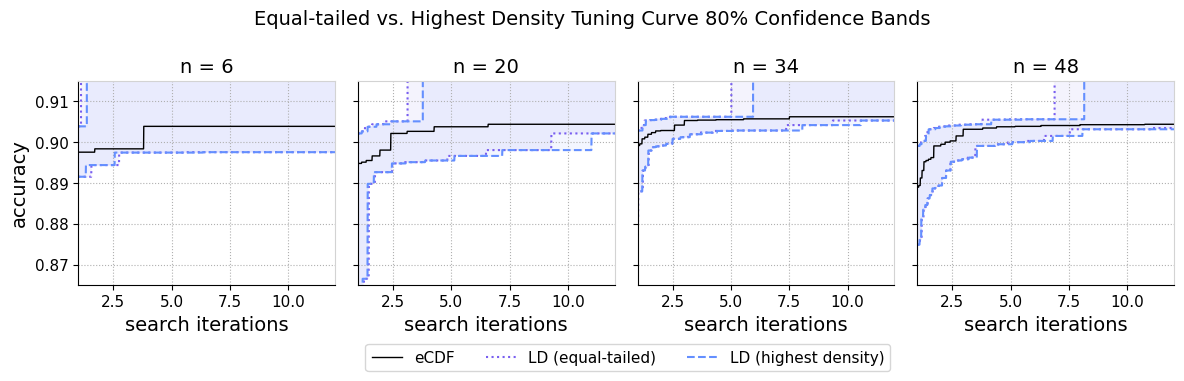

In [11]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 3.5),
)
for i, sample_size_ in enumerate(sample_sizes):
    ys = generator.choice(
        model_to_evaluation_to_ys[model][evaluation],
        size=sample_size_,
        replace=False,
    )

    axes[i].plot(
        ns_grid,
        nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
        linewidth=1,
        linestyle="-",
        color="k",
        label="eCDF",
    )

    for band_ in ["ld_equal_tailed", "ld_highest_density"]:
        lower_cdf, _, upper_cdf =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        axes[i].plot(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            label=bands[band_]["name"],
            **bands[band_]["style"],
        )
        axes[i].plot(
            ns_grid,
            lower_cdf.quantile_tuning_curve(ns_grid),
            **bands[band_]["style"],
        )
        axes[i].fill_between(
            ns_grid,
            upper_cdf.quantile_tuning_curve(ns_grid),
            lower_cdf.quantile_tuning_curve(ns_grid),
            alpha=0.075,
            **bands[band_]["style"],
        )

# Format the plot.
axes[0].set_ylabel("accuracy")

for i, sample_size_ in enumerate(sample_sizes):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.865, 0.915)
    axes[i].set_xlabel("search iterations")
    axes[i].set_title(f"n = {sample_size_}")
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"Equal-tailed vs. Highest Density Tuning Curve {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1].legend(
    loc="upper left",
    bbox_to_anchor=(0., -0.25),
    ncol=3,
)

plt.show()

and DeBERTa and DeBERTaV3 are again highly similar:

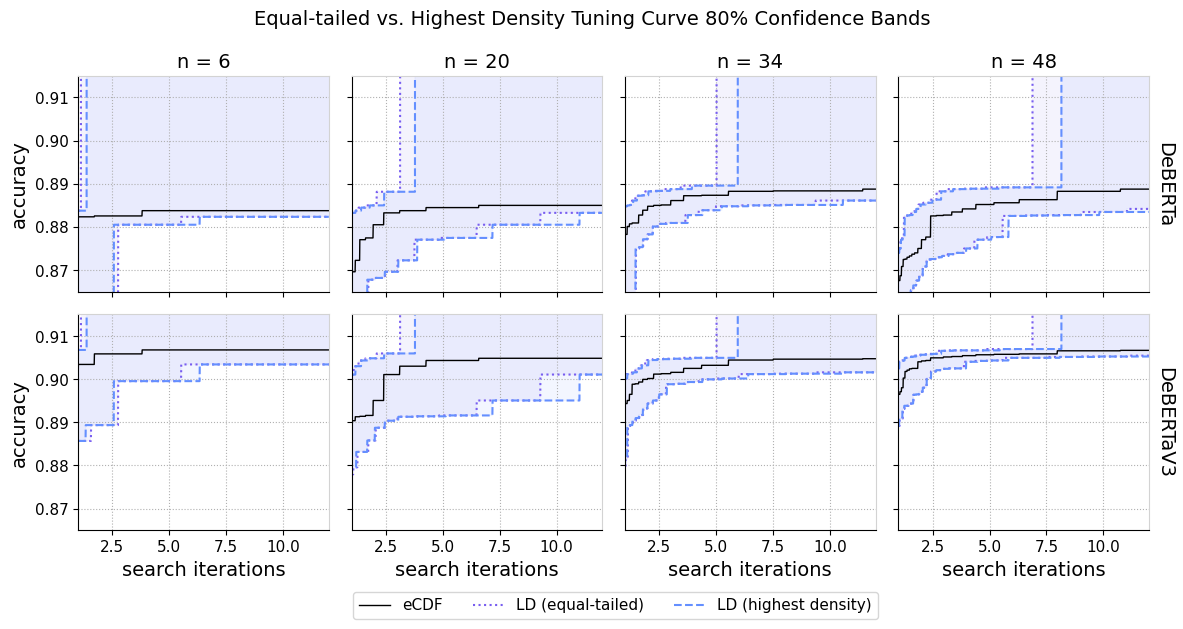

In [12]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=4,
    sharex=True,
    sharey=True,
    figsize=(12, 6),
)
for i, model_ in enumerate(models):
    for j, sample_size_ in enumerate(sample_sizes):
        ys = generator.choice(
            model_to_evaluation_to_ys[model_][evaluation],
            size=sample_size_,
            replace=False,
        )

        axes[i, j].plot(
            ns_grid,
            nonparametric.EmpiricalDistribution(ys).quantile_tuning_curve(ns_grid),
            linewidth=1,
            linestyle="-",
            color="k",
            label="eCDF",
        )

        for band_ in ["ld_equal_tailed", "ld_highest_density"]:
            lower_cdf, _, upper_cdf =\
                nonparametric.EmpiricalDistribution.confidence_bands(
                    ys,
                    confidence=confidence,
                    a=y_min,
                    b=y_max,
                    method=band_,
                )

            axes[i, j].plot(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                label=bands[band_]["name"],
                **bands[band_]["style"],
            )
            axes[i, j].plot(
                ns_grid,
                lower_cdf.quantile_tuning_curve(ns_grid),
                **bands[band_]["style"],
            )
            axes[i, j].fill_between(
                ns_grid,
                upper_cdf.quantile_tuning_curve(ns_grid),
                lower_cdf.quantile_tuning_curve(ns_grid),
                alpha=0.075,
                **bands[band_]["style"],
            )

# Format the plot.
for j, sample_size_ in enumerate(sample_sizes):
    axes[1, j].set_xlabel("search iterations")
    axes[0, j].set_title(f"n = {sample_size_}")

for i, model_ in enumerate(models):
    axes[i, 0].set_ylabel("accuracy")
    axes[i, -1].yaxis.set_label_position("right")
    axes[i, -1].set_ylabel(models[model_]["name"], labelpad=18, rotation=270)

for i in range(len(models)):
    for j in range(len(sample_sizes)):
        axes[i, j].set_xlim(1, n // 4)
        axes[i, j].set_ylim(0.865, 0.915)
        axes[i, j].spines["right"].set_color("lightgrey")
        axes[i, j].spines["top"].set_color("lightgrey")

fig.suptitle(
    f"Equal-tailed vs. Highest Density Tuning Curve {100 * confidence:.0f}% Confidence Bands",
)

fig.tight_layout()

axes[1, 1].legend(
    loc="upper left",
    bbox_to_anchor=(-0.025, -0.25),
    ncol=3,
)

plt.show()

We can use the linear relationship between sample size and where the upper bound becomes trivial to quantify the data efficiency gained by using the highest density instead of the equal-tailed LD bands. Consider the slope for the two different methods:

In [13]:
# Fit lines to the sample size vs. trivial bound iteration relationship.
for band_ in ["ld_equal_tailed", "ld_highest_density"]:
    trivial_bound_iterations = []
    for sample_size_ in sample_sizes:
        ys = generator.choice(
            model_to_evaluation_to_ys[model][evaluation],
            size=sample_size_,
            replace=False,
        )

        lower_cdf, _, _ =\
            nonparametric.EmpiricalDistribution.confidence_bands(
                ys,
                confidence=confidence,
                a=y_min,
                b=y_max,
                method=band_,
            )

        trivial_bound_iterations.append(
            ns_grid[np.argmax(lower_cdf.quantile_tuning_curve(ns_grid))],
        )

    # Fit a linear regression to the sample size/trivial bound iteration data.
    regression = stats.linregress(sample_sizes, trivial_bound_iterations)

    print(
        f'{bands[band_]["name"]: <20}: '
        f' y = {regression.slope:.3f}x + {regression.intercept:.3f}',
    )

LD (equal-tailed)   :  y = 0.137x + 0.345
LD (highest density):  y = 0.161x + 0.477


Since the intercepts are about equal, we can approximate the reduction in data requirements by the ratio of the slopes, or about 85%. In other words, the highest density bands require about 15% less data to bound the tuning curve up to the same point as the equal-tailed bands at 80% confidence. Note that this relationship *doesn't* depend on the model or technique being tuned, because the width of the bands at each order statistic (and thus at the maximum) is fixed and independent of the data. The shape of the bands only depends on the data through the *location* of the order statistics. Therefore, the highest density bands will always require about 15% less data to achieve a nontrivial bound at the same point as the equal-tailed bands at 80% confidence. Other confidence levels show a similar relationship, though with different levels of data savings.

## Issues with Expected Tuning Curves

While our analysis focuses on *median* tuning curves, the basic approach also constructs conservative confidence bands for *mean* tuning curves. We emphasize the median because it has several advantages over the mean.

As a summary of a distribution, the mean is most interpretable when averaging or summing over a large number of samples, in which case the central limit theorem and law of large numbers apply. Without taking any kind of sum, the mean can be difficult to interpret&mdash;especially if the distribution is skewed. In contrast, the median always has a simple interpretation: the result is equally often above and below it.

The other issue with the mean is that it's difficult to bound in a nonparametric, distribution-free way. Without bounds on the random variable's support, a very small probability can be assigned to an arbitrarily large number. Thus, you'll never observe the number in a sample, but nonetheless the mean can be huge.

Due to this problem and the fact that our confidence bands are distribution-free, they can only bound the mean tuning curve when given proper bounds on the test metric. Even with these bounds, however, the issue causes the mean tuning curve confidence bands to be conservative, rather than exact, and to converge slowly. Comparing the median and mean tuning curve confidence bands, we observe this effect:

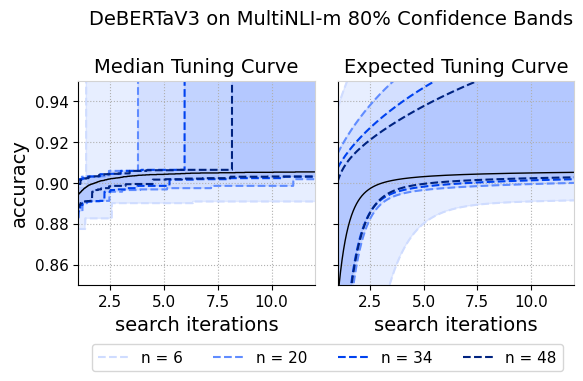

In [14]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    sharex=True,
    sharey=True,
    figsize=(6, 3.5),
)

# Plot the confidence bands for various sample sizes.
ys = generator.choice(
    model_to_evaluation_to_ys[model][evaluation],
    size=n,
    replace=False,
)
for sample_size_ in sample_sizes:
    # Construct the confidence bands.
    lower_cdf, _, upper_cdf =\
        nonparametric.EmpiricalDistribution.confidence_bands(
            ys[:sample_size_],
            confidence=confidence,
            a=y_min,
            b=y_max,
            method=band,
        )

    # Lighten the band color for the sample size.
    color = visualization.color_with_lightness(
        c=bands[band]["style"]["color"],
        lightness=0.75 * (1 - sample_size_ / n) + 0.25,
    )

    # Plot the median tuning curve confidence bounds.
    axes[0].plot(
        ns_grid,
        lower_cdf.quantile_tuning_curve(ns_grid),
        label=f"n = {sample_size_}",
        **{**bands[band]["style"], "color": color},
    )
    axes[0].plot(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        **{**bands[band]["style"], "color": color},
    )
    # The fill color does not need to be modified because it has
    # transparency, so the fills stack on top of each other.
    axes[0].fill_between(
        ns_grid,
        upper_cdf.quantile_tuning_curve(ns_grid),
        lower_cdf.quantile_tuning_curve(ns_grid),
        alpha=0.15,
        color=bands[band]["style"]["color"],
    )

    # Plot the average tuning curve confidence bounds.
    axes[1].plot(
        ns_grid,
        lower_cdf.average_tuning_curve(ns_grid),
        label=f"n = {sample_size_}",
        **{**bands[band]["style"], "color": color},
    )
    axes[1].plot(
        ns_grid,
        upper_cdf.average_tuning_curve(ns_grid),
        **{**bands[band]["style"], "color": color},
    )
    # The fill color does not need to be modified because it has
    # transparency, so the fills stack on top of each other.
    axes[1].fill_between(
        ns_grid,
        upper_cdf.average_tuning_curve(ns_grid),
        lower_cdf.average_tuning_curve(ns_grid),
        alpha=0.15,
        color=bands[band]["style"]["color"],
    )

# Construct our best estimate of the ground truth CDF.
point_cdf = nonparametric.EmpiricalDistribution(
    model_to_evaluation_to_ys[model][evaluation],
    a=y_min,
    b=y_max,
)
# Plot our best estimate of the ground truth median tuning curve.
axes[0].plot(
    ns_grid,
    point_cdf.quantile_tuning_curve(ns_grid),
    linewidth=1,
    linestyle="-",
    color="k",
)
# Plot our best estimate of the ground truth average tuning curve.
axes[1].plot(
    ns_grid,
    point_cdf.average_tuning_curve(ns_grid),
    linewidth=1,
    linestyle="-",
    color="k",
)

# Format the plot.
axes[0].set_ylabel("accuracy")

for i, aggregate in enumerate(["median", "expected"]):
    axes[i].set_xlim(1, n // 4)
    axes[i].set_ylim(0.85, 0.95)
    axes[i].spines["right"].set_color("lightgrey")
    axes[i].spines["top"].set_color("lightgrey")
    axes[i].set_xlabel("search iterations")
    axes[i].set_title(f"{aggregate.capitalize()} Tuning Curve")

fig.suptitle(
    f'{models[model]["name"]} on {evaluations[evaluation]["name"]}'
    f' {confidence * 100:.0f}% Confidence Bands',
    x=0.565,
)

fig.tight_layout()

axes[0].legend(
    loc="upper left",
    bbox_to_anchor=(0.025, -0.25),
    ncol=len(sample_sizes),
)

plt.show()

The median tuning curve confidence bands converge quickly where they provide a nontrivial bound, while the mean tuning curve confidence bands converge slowly across the entire curve. Thus, while the median tuning curve confidence bands enable useful comparisons on the initial part of the curve, the mean tuning curve confidence bands need large sample sizes before yielding useful conclusions.